##Downloads of packages and usefull imports.

In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.0MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=06feb7fdb40f15ff6872db82e4b64a4772154d908f2bc325a73eb1a30ed54b46
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=2be0ba7d841215c40548d3ddde1b63277971f2822a3ef9234bd48d96c2562959
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=c37dfdf8483c36ec380c788ac4b8943e6c78b0d40c3641485257541831267391
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

#import nltk
#nltk.download('punkt')
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#from nltk.stem import PorterStemmer

import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import bert
from bert.tokenization.bert_tokenization import FullTokenizer

#from bert import BertModelLayer
#from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Download the data from my personal drive(Google collab deletes folders) and store the concatenation of all the datasets into 'data/total.csv'.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
websites = ['amazon', 'imdb', 'yelp']
df_list_web=[]
for website in websites:
  df_web = pd.read_csv('/content/drive/My Drive/data/' + website + '_labelled.txt', sep="\\t", header=None)
  df_list_web.append(df_web)
df= pd.concat(df_list_web, axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [5]:
os.makedirs("data", exist_ok=True)

In [6]:
df.columns = ['text', 'score']
df.to_csv('data/total.csv')
df

,text,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


#Data Analysys
Search any interesting facts that can help us on the preprocessing stages.

In [7]:
df.text.isnull().sum()

0

In [8]:
df.score.isnull().sum()

0

In [9]:
print('Positive review example: \n', df[df.score==1].text.values[0])
print('\n')
print('Negative review example: \n', df[df.score==0].text.values[0])

Positive review example: 
 Good case, Excellent value.


Negative review example: 
 So there is no way for me to plug it in here in the US unless I go by a converter.


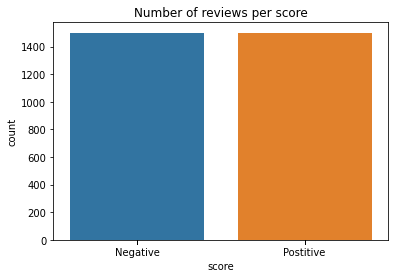

In [10]:
chart = sns.countplot(df.score)
plt.title("Number of reviews per score")
plt.xticks(df.score, ['Negative', 'Postitive']);

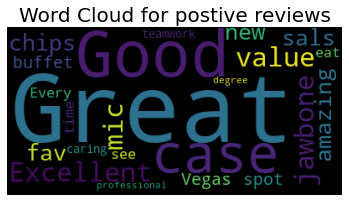

In [11]:
positive = df[(df['score']==1)]
wc_pos = WordCloud().generate(str(positive['text'].values))
negative = df[(df['score']==0)]
wc_neg = WordCloud().generate(str(negative['text'].values))

plt.figure()
plt.imshow(wc_pos)
plt.axis('off')
plt.title('Word Cloud for postive reviews',fontsize=20)
plt.show()

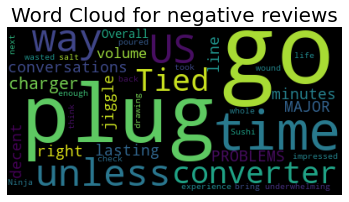

In [12]:
plt.figure()
plt.imshow(wc_neg)
plt.axis('off')
plt.title('Word Cloud for negative reviews',fontsize=20)
plt.show()    

The Word Clouds will give us a deep dive into the most common words for the either positive reviews or negative. As seen before, the most used words on positive reviews are great and good, while in the negative are plug and go. This gives as an idea of what type of reviews we have.

In this case the negatives usually have reference to some electric device as the plug word appears a lot.

#Preprocessing
Once the data is succesfully analyzed we will start the preprocessing taking into account important features from the previous step.

In [13]:
#Puntuation and numbers removal, most of them not providing information for sentiment analysis.
words = df.text.apply(lambda x: re.sub(r'\W+',' ',x))

#Lower Case all text
words = words.apply(lambda x: x.lower())

#Removal of Stop words
#stop_words = stopwords.words('english')
#tokens = words_lower.apply(lambda row: nltk.word_tokenize(row))
#words = tokens.apply(lambda x: [word for word in x if not word in stop_words])
#words = words.apply(lambda x: ' '.join(x))

#Stemming
#tokens = words_lower.apply(lambda row: nltk.word_tokenize(row))
#words = tokens.apply(lambda x: [ps.stem(w) for w in x])
#words = words.apply(lambda x: ' '.join(x))

#Add Changes to df.
df.text = words

We will keep stopwords as most of them bring negation and context information Bert is able to take profit of.
The same happens with Stemming or Lemmatization as the model losses information that helps to predict the sentiment.

#Downloading the model

In [14]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2020-09-18 07:23:07--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  84.0MB/s    in 4.6s    

2020-09-18 07:23:12 (84.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [15]:
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

In [16]:
bert_model_name= 'uncased_L-12_H-768_A-12'

bert_ckpt_dir = os.path.join('model/',bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

#Preprocessing data for Bert
In order to make the pretrained language model(Bert) understand our data it has to come on a specific format. To achieve this we developed a class with some functions to perform all the steps.

The init function initializes the class with all the parameters that we pass on it.

The encodebert converts the train/test dataset into train_x/test_y and train_y/test_y. The text is converted to tokens and added some special caracthers needed to delimiter sentences.

The pad, appart from padding the sentences to the length of the largest, it creates the token_ids, the mask_id and the input_type_ids matrixs. 

In [17]:
class BertData:

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer=tokenizer
    self.max_seq_len=0
    self.classes=classes

    ((self.train_x, self.train_y), (self.test_x,self.test_y)) = map(self._encodebert, [train,test])

    self.max_seq_len=min(self.max_seq_len,max_seq_len)
    
    ((self.train_x, self.train_mask, self.train_type), (self.test_x, self.test_mask, self.test_type)) = map(self._pad,[self.train_x, self.test_x])
  

  def _encodebert(self, df):
    x, y= [], []
    for _,row in tqdm(df.iterrows()):
      text,label= row['text'], row['score']

      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"]+tokens+["[SEP]"]

      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      self.max_seq_len= max(self.max_seq_len, len(token_ids))

      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)


  def _pad(self, ids):
    #print("Max_Seq_Len Value:", self.max_seq_len)
    x, y, z =[],[], []
    
    for input_ids in ids:
      
      #Mask generation:
      mask = ([1] * len(input_ids)) + ([0] *  (self.max_seq_len - len(input_ids)))
      #Input type generation:
      input_type = ([0] * (len(input_ids)-1)) + [1] + ([0] *  (self.max_seq_len - len(input_ids)))
      #Input ids generation:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))

      x.append(np.array(input_ids))
      y.append(np.array(mask))
      z.append(np.array(input_type))

    return np.array(x), np.array(y), np.array(z)



In [18]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir,"vocab.txt"))

In [19]:
#tokenizer.tokenize("I can't wait to learn more about Deep Learning.")

In [20]:
import tensorflow_hub as hub
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

#Model Creation
To make Bert work correctly, we need the data in the format mentioned before. So the input to the bert layer will be [input_ids, input_mask, input_segments]. Then we fine-tune the lasts layers in order to make the model be able to perform corretly on our type of problem, in our case, sentiment analysis.

In [21]:
def create_model(max_seq_len):

  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_segments")

  _,bert_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(bert_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(units=768)(logits)
  logits = keras.layers.Dropout(0.7)(logits)

  #Enable the row below when logits=True
  logits = keras.layers.Dense(units=1, activation="sigmoid")(logits)

  #Enable the row below when Loss logits=False, worse results thant with logits
  #logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model([input_ids, input_mask, input_segments],logits)
        
  return model

In [22]:
train,test = train_test_split(df, test_size=0.2, random_state=43)

In [23]:
classes = train.score.unique().tolist()
data = BertData(train, test, tokenizer, classes, max_seq_len=128)

2400it [00:01, 2204.15it/s]
600it [00:00, 2221.81it/s]


In [24]:
model = create_model(data.max_seq_len)

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 87)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 87)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 87)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]     

In [26]:
#data.train_x[0]

In [27]:
#data.train_mask[0]

In [28]:
#train.text[0]

In [29]:
#data.train_x[0]

The parameters of the compile are given by the Bert documentation where they suggest some of them. The loss function is given by the type of problem.

In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

As the bert layer only accepts data in tensors of int32 we convert the 3 matrix into a tensor in order to make the layer understand.

In [31]:
bert_input = [tf.cast(data.train_x, tf.int32), tf.cast(data.train_mask, tf.int32), tf.cast(data.train_type, tf.int32)]
bert_input

[<tf.Tensor: shape=(2400, 87), dtype=int32, numpy=
 array([[  101,  1996, 20130, ...,     0,     0,     0],
        [  101, 13877,  2001, ...,     0,     0,     0],
        [  101,  1996,  9682, ...,     0,     0,     0],
        ...,
        [  101,  1996,  2304, ...,     0,     0,     0],
        [  101,  2833,  2001, ...,     0,     0,     0],
        [  101,  2065,  2045, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(2400, 87), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2400, 87), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>]

This are some callbacks, the first one as the name says, stops the training process once the model has not improved after x steps.
The second one is only for storing the best version of the model.

In [32]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

checkpoint = ModelCheckpoint('model/best.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

In [33]:
history = model.fit(
    x=bert_input, 
    y=data.train_y, 
    validation_split=0.1, 
    batch_size=16, 
    shuffle=True,
    epochs=5,
    callbacks=[earlystop, checkpoint]
    )

Epoch 1/5
135/135 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6588WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0134s vs `on_test_batch_end` time: 0.1630s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 0.57020, saving model to model/best.h5
135/135 [==============================] - 85s 627ms/step - loss: 0.6439 - accuracy: 0.6588 - val_loss: 0.5702 - val_accuracy: 0.8875
Epoch 2/5
135/135 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.9171
Epoch 00002: val_loss improved from 0.57020 to 0.55857, saving model to model/best.h5
135/135 [==============================] - 83s 613ms/step - loss: 0.5388 - accuracy: 0.9171 - val_loss: 0.5586 - val_accuracy: 0.9167
Epoch 3/5
135/135 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.9505
Epoch 00003: val_loss improved from 0.55857 to 0.55764, saving model to model/best.h5
135/135 [==============================] - 83s 613ms/step - loss: 0.5242 - accuracy: 0.9505 - val_loss: 0.5576 - val_accuracy: 0.9292
Epoch 4/5
135/135 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.9588
Epoch 00004: val_loss improved from 0.55764 to 0.55377, sa

#Result Analysis

Once the training finished, we will test our model on the remaining data (test dataset). 

In [34]:
bert_test_inp = [tf.cast(data.test_x, tf.int32), tf.cast(data.test_mask, tf.int32), tf.cast(data.test_type, tf.int32)]
_, test_acc= model.evaluate(bert_test_inp, data.test_y)

print("test acc:", test_acc)

19/19 [==============================] - 6s 341ms/step - loss: 0.5292 - accuracy: 0.9450
test acc: 0.9449999928474426


More than 94% of accuracy on the test dataset is pretty good. But this brings no information on what type of data are we missclasifying. 

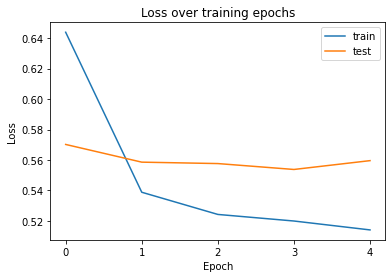

In [35]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
#plt.ylim([0,1])
plt.show();

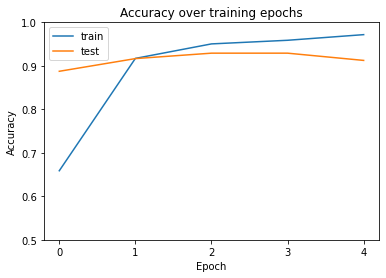

In [40]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.ylim([0.5,1])
plt.show();

In [37]:
y_test_pred = model.predict(bert_test_inp)
y_test_pred2=[]
for i in y_test_pred:
  if (i < 0.5):
    i= 0
  else:
    i = 1
  y_test_pred2.append(i)
y_test_pred2[0:10]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 0]

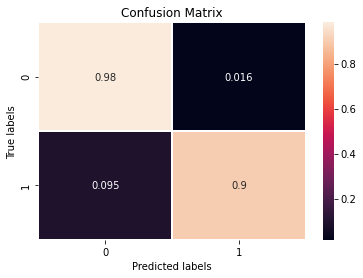

In [38]:
y_test_true = data.test_y
cm = confusion_matrix(y_test_true, y_test_pred2, normalize='true')


ax = plt.subplot()
sns.heatmap(cm, annot=True, linewidth=.5)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');


The confusion matrix matrix gives much more information than the accuracy by itself. Here with this plot, we know that the prediction error on negative reviews is almost perfect, but on the positive ones we miss much more (90%).

To discover what is causing this we will need to analyse the positive reviews that are missclasified as negative ones and check if there is something that can make the model perform wrong predictions. 

In [39]:
print(classification_report(y_test_true, y_test_pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       306
           1       0.98      0.90      0.94       294

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600

